<a href="https://colab.research.google.com/github/cicerotcv/iris-recognition/blob/master/projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **VISÃO COMPUTACIONAL - AULA 04**

**Objetivos da aula:**

*   conhecer o software G6-iris-recognition
*   praticar com o software G6-iris-recognition
*   especificar a competição de reconhecimento de íris dentro do curso









**Instalação do Módulo G6 (Gate 6)**

Documentação do Módulo G6: https://pypi.org/project/G6-iris-recognition/ 

Para instalar o módulo de reconhecimento de íris G6, seguir os passos abaixo:

1. Atualizar o módulo scikit-image do Google Colab:

In [513]:
from os import listdir, system, mkdir
import shutil
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

try:
    import skimage
    print("scikit-image already installed")
except ImportError:
    !pip3 install scikit-image --upgrade
    import skimage
    
try:
    import imutils
    print("imutils already installed")
except ImportError:
    system("pip3 install imutils")
    import imutils

scikit-image already installed
imutils already installed


In [514]:
def create_pickle(pickle_name: str = 'model.pickle'):
    if pickle_name not in listdir('./'):
        open(pickle_name, 'w+').close()

def git_clone(repo_url: str, output_dir: str):
    system(f"git clone {repo_url} {output_dir}")
    print(f"Git repository cloned into '{output_dir}'")


def clean_git(dir: str):
    # função que apaga .git da pasta {dir}
    pass

def put_text(img:np.ndarray, text:str):
    img = img.copy()
    font = cv.FONT_HERSHEY_SIMPLEX
    font_thickness = 2
    font_scale = 1
    (img_height, img_width, depth) = img.shape
    (text_width, text_height), baseline = cv.getTextSize(text, font, font_scale, font_thickness)
    x = (img_width - text_width)//2
    y = 5 + text_height + baseline
    cv.putText(img, text, (x, y), font, font_scale, (100, 0, 0), font_thickness, cv.LINE_AA)
    return img
    
def cv_imshow(img, text=None):
    if text != None:
        img = put_text(img, text)
    plt.figure(figsize = (20, 4))
    plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.show()

def ensure_path_exists(path:str):
    source = "."
    for subfolder in path.strip('/').split('/'):
        next_level = source + '/' + subfolder
        if subfolder not in listdir(source):
            mkdir(next_level)
        source = next_level
        
def img_save(img, source_dir, category, img_name):
    source_tmp = source_dir + "_tmp"
    ensure_path_exists(f"{source_tmp}/{category}")
    full_path = f'{source_tmp}/{category}/{img_name}'
    cv.imwrite(full_path, img)

def gray2bgr(gray):
    return cv.cvtColor(gray, cv.COLOR_GRAY2BGR)

def bgr2gray(bgr):
    return cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

   2. Fazer um clone do módulo G6 Iris Recognition do repositório abaixo:

In [515]:
G6_git_url = 'https://github.com/lucianosilva-github/G6_iris_recognition.git'
G6_output_dir = 'G6_iris_recognition'

git_clone(G6_git_url, G6_output_dir)
# não esquecer de deletar .git da pasta {G6_output_dir} 
!rm -rf  /content/G6_iris_recognition/.git

Git repository cloned into 'G6_iris_recognition'


   3. Fazer um clone do banco de imagens de iris:

In [516]:
input_url = 'https://github.com/lucianosilva-github/images'
input_dir = 'images'

git_clone(input_url, input_dir)
# não esquecer de deletar .git da pasta {input_dir} 
!rm -rf  /content/images/.git

Git repository cloned into 'images'


```python
tutorial_git_url = "https://github.com/lucianosilva-github/images-tutorial.git"
tutorial_output_dir = "images-tutorial"

git_clone(tutorial_git_url, tutorial_output_dir)
# não esquecer de deletar .git da pasta {tutorial_output_dir} 
```

   4. Criar o arquivo vazio model.pickle 

In [517]:
create_pickle('model.pickle')

**Uso do Módulo G6 (Gate 6)**

Existem três passos para uso do módulo de reconhecimento de íris G6:

1.   **Criação do arquivo vazio de modelo de reconhecimento** (model.pickle), que será preenchido pelo módulo G6. 

2.   **Construção de um modelo de reconhecimento** (model.pickle), tendo como base um banco de dados de imagens. Este banco deve ser organizado dentro de uma pasta (images-tutorial, no nosso exemplo) e, o conjunto de íris de cada pessoa, deve estar dentro de uma pasta. Por exemplo, images-tutorial/0002 irá indicar o conjunto de íris da pessoa 0002.
3.   **Uso do modelo de reconhecimento** (model.pickle), onde colocamos a imagem que queremos reconhecer. No exemplo abaixo, estamos tentando reconhecer a íris da primeira pessoa, através do arquivo images-tutorial/0002/0002_000.bmp.






In [518]:
def increase_contrast(img: np.ndarray, alpha=1.5, beta=0):
    """
    `Contrast control (1.0-3.0)` \\
    `Brightness control (0-100)`
    """
    img = img.copy()
    adjusted = cv.convertScaleAbs(img, alpha=alpha, beta=beta)
    return adjusted

In [519]:
def white_equalizer(img: np.ndarray):
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gray = cv.equalizeHist(img_gray)
    return cv.cvtColor(img_gray, cv.COLOR_GRAY2BGR)

In [520]:
def fix_contrast(img: np.ndarray):
    img_copy = img.copy()
    img_hsv = cv.cvtColor(img_copy, cv.COLOR_BGR2HSV)
    (H,S,V) = cv.split(img_hsv)
    V = cv.equalizeHist(V)
    merge = cv.merge( (H,S,V) )
    return cv.cvtColor(merge, cv.COLOR_HSV2BGR)

In [521]:
def sharpen_img(img):
    img_copy = img.copy()
    kernel = np.array([[-1, -1, -1], 
                       [-1,  9, -1],
                       [-1, -1, -1]])
    img_copy = cv.filter2D(img_copy, -1, kernel)
    return img_copy

In [522]:
def blur_img(img, shape=(10,10)):
    return cv.blur(img, ksize=shape)

In [523]:
def invert_img(img:np.ndarray):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    invert = cv.bitwise_not(gray) 
    return cv.cvtColor(invert, cv.COLOR_GRAY2BGR)

In [524]:
def adjust_gamma(img, gamma=1.90):
    # https://lindevs.com/apply-gamma-correction-to-an-image-using-opencv/
    invGamma = 1 / gamma
 
    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
 
    return cv.LUT(img, table)

In [525]:
def eq_bimodal(img: np.ndarray):
  img_copy = img.copy()
  print("copy", img_copy.shape)
  # img_gray = bgr2gray(img_copy)
  # print("gray", img_gray.shape)


  # imgt = cv.adaptiveThreshold(img_copy,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_OTSU,5,6)
  T,imgt = cv.threshold(img_copy,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

  return imgt

In [526]:
def magic(img: np.ndarray):
  img_copy = img.copy()
  mag = cv.createCLAHE(clipLimit = 2.0, tileGridSize= (8,8))
  mag_img = mag.apply(img)
  return mag_img


In [527]:
def process_img(img_before: np.ndarray, equalize=False, contrast=False, alpha=1.8, beta=-10, gamma=1.9, blur_shape=(5,6), sharpen=True, blur=True, bimodal=True):
    img = img_before.copy()
    
    if sharpen:
        img = sharpen_img(img)
    if blur:
        img = blur_img(img, blur_shape)
    if equalize:
        img = white_equalizer(img)
    if contrast:
        img = fix_contrast(img)
    if alpha != 1 or beta != 0:
        img = increase_contrast(img, alpha=alpha, beta=beta)
    if gamma != 1:
        img = adjust_gamma(img, gamma)
    # if bimodal:
    #     img = eq_bimodal(img)

    return img

In [528]:
def remove_noise(gray, num):
    Y, X = gray.shape
    nearest_neigbours = [[
        np.argmax(
            np.bincount(
                gray[max(i - num, 0):min(i + num, Y), max(j - num, 0):min(j + num, X)].ravel()))
        for j in range(X)] for i in range(Y)]
    result = np.array(nearest_neigbours, dtype=np.uint8)
    return result

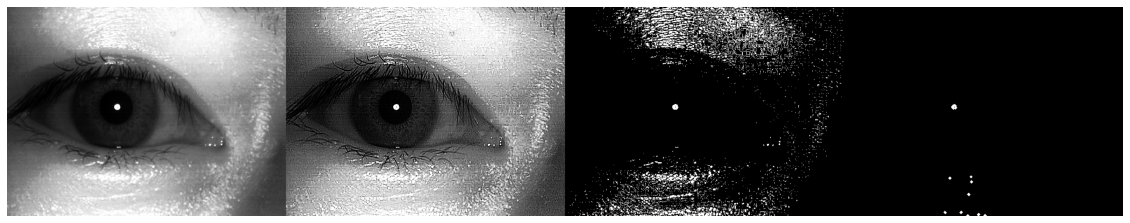

In [529]:
def remove_reflex(img:np.ndarray, thresh=150):
    gray = white_equalizer(img)
    gray = bgr2gray(gray)
    sharpened = sharpen_img(gray)
    
    _, thresholded = cv.threshold(sharpened, 250, 255, 0)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))

    n_iterations = 3
    closed = cv.dilate(cv.erode(thresholded, kernel, iterations=n_iterations), kernel, iterations=n_iterations)
    
    cv_imshow(np.hstack((
        gray,
        sharpened,
        thresholded,
        closed,
    )))

test_img = cv.imread(f'{input_dir}/0002/0002_001.bmp')
remove_reflex(test_img)

In [530]:
transformation_functions = {
    'default': lambda img: process_img(img, equalize=False, contrast=False, alpha=1, beta=0, gamma=1, sharpen=False, blur=False, bimodal=True),
    '0002': lambda img: process_img(img, equalize=True, contrast=True, alpha=3, beta=-10, gamma=1, sharpen=True, blur=True, bimodal=True),
    '0003': lambda img: process_img(img, equalize=True, contrast=True, alpha=3, beta=-10, gamma=1, sharpen=True, blur=True, bimodal=True),
}

In [531]:
def process_category(source, category, show=True, save=False, skip=0, limit=None):
    limit = skip + limit if limit != None else None
    for img_name in listdir(f'{source}/{category}')[skip:limit]:
        img_path = f'{source}/{category}/{img_name}'
        img_before = cv.imread(img_path)

        if category not in transformation_functions.keys():
            category = 'default'
        transform = transformation_functions.get(category)

        img_after = transform(img_before)
        img_invert = invert_img(img_after)

        if save:
            img_save(img_after, source, category, img_name)
        if show:
            cv_imshow(np.hstack((
                img_before, 
                img_after, 
                img_invert,
            )), text=img_name)

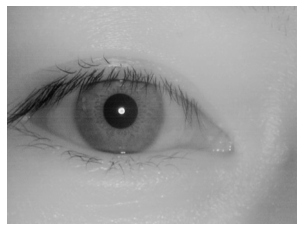

copy (480, 640)
(480, 640)


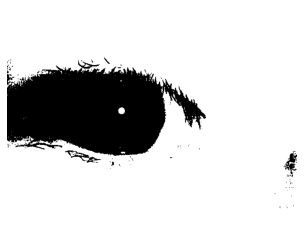

In [532]:
# /content/images/0000/0000_000.bmp
img = cv.cvtColor(cv.imread('/content/images/0002/0002_001.bmp'), cv.COLOR_BGR2GRAY)
cv_imshow(img)
imgt = eq_bimodal(img)
print(imgt.shape)
cv_imshow(imgt)

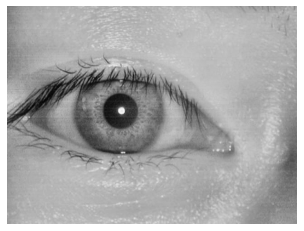

copy (480, 640)


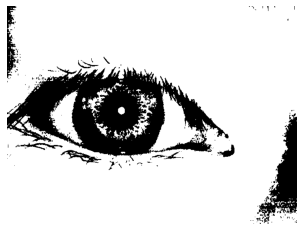

In [533]:
magia = magic(img)
cv_imshow(magia)
imgt2 = eq_bimodal(magia)
cv_imshow(imgt2)

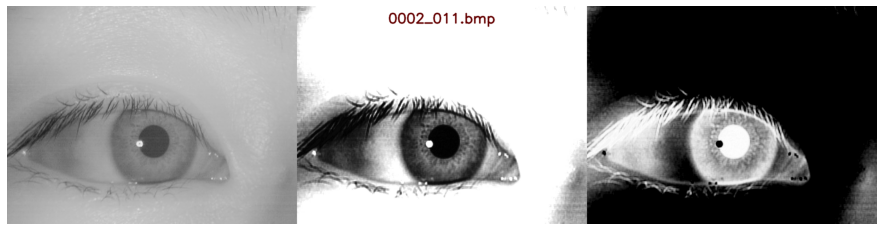

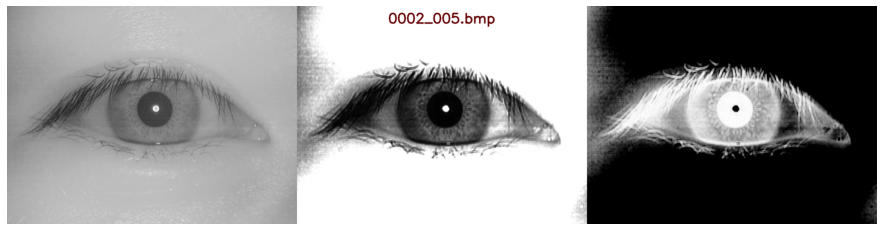

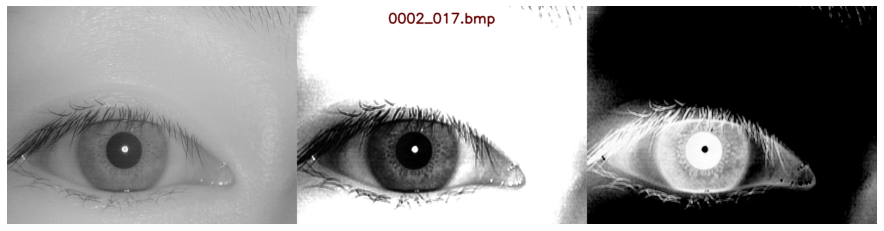

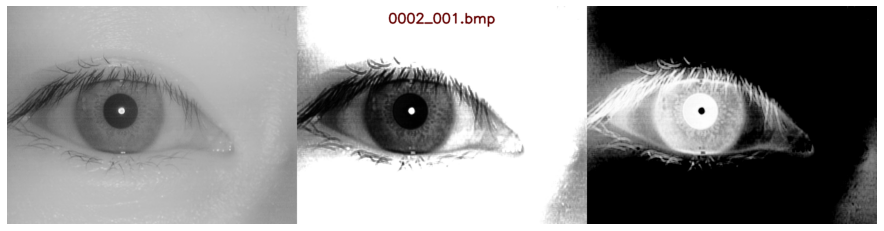

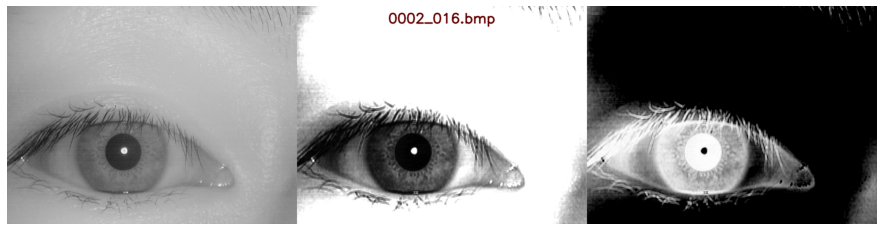

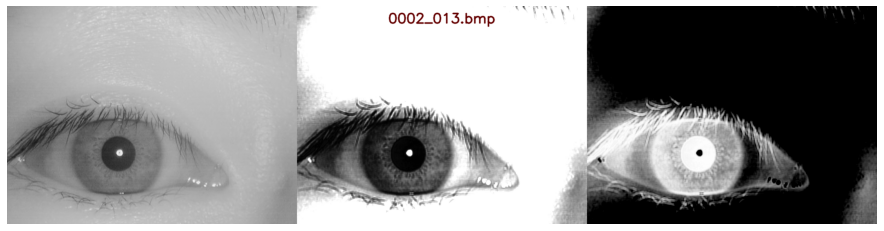

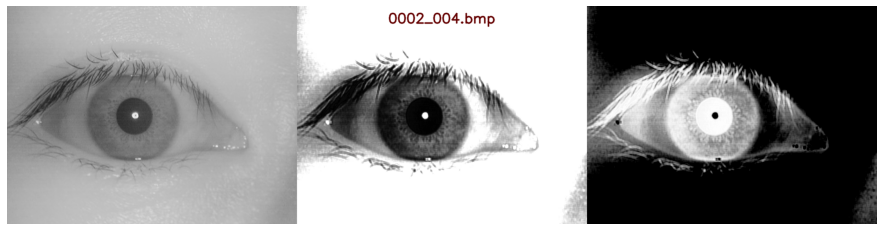

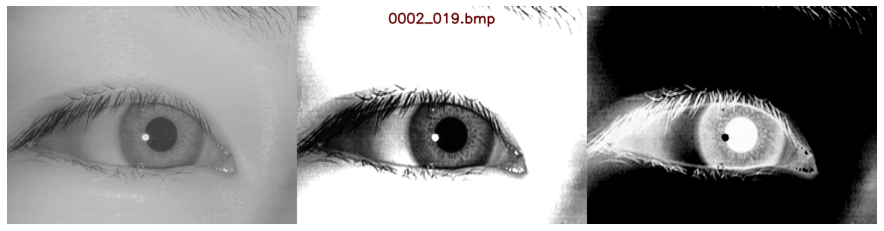

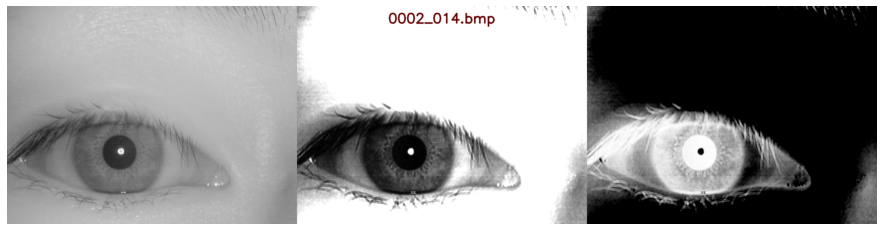

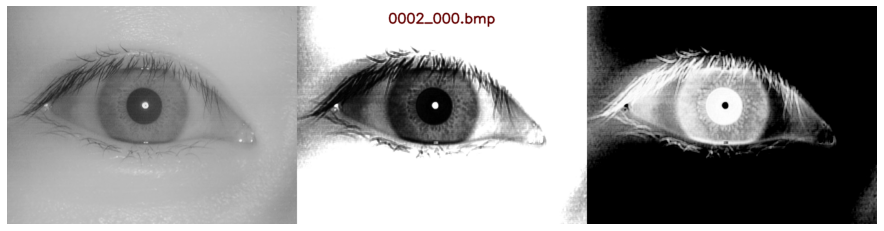

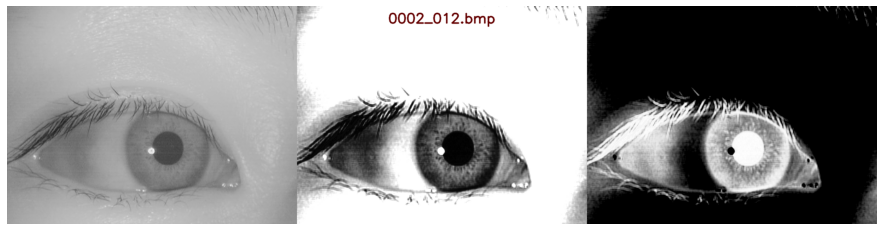

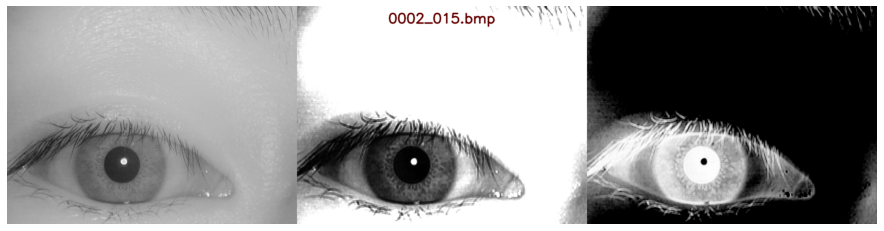

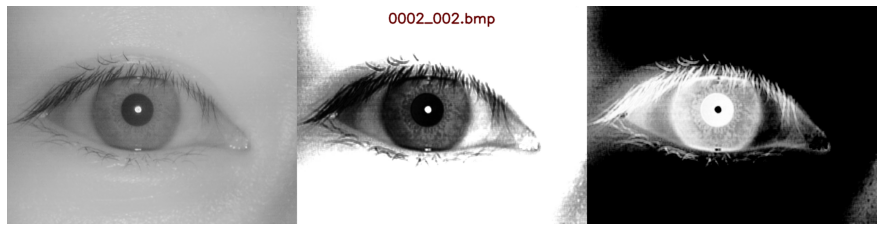

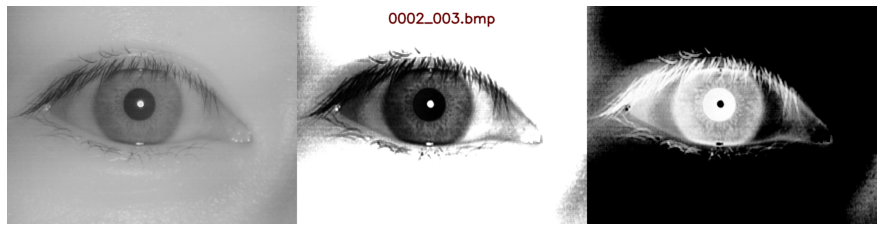

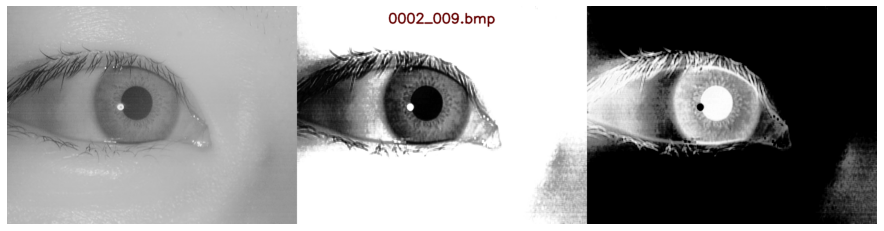

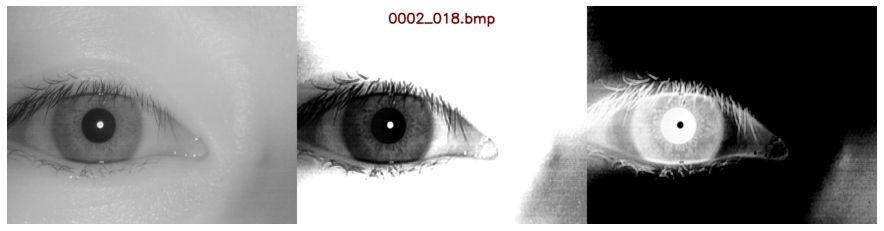

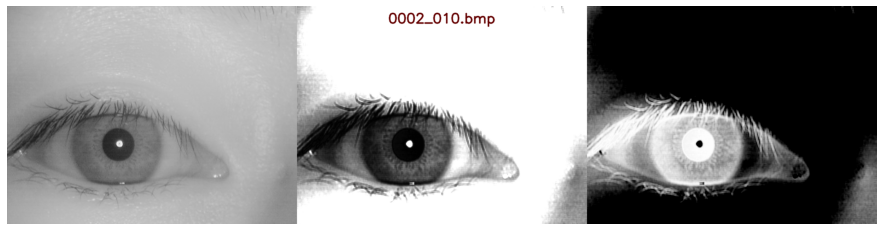

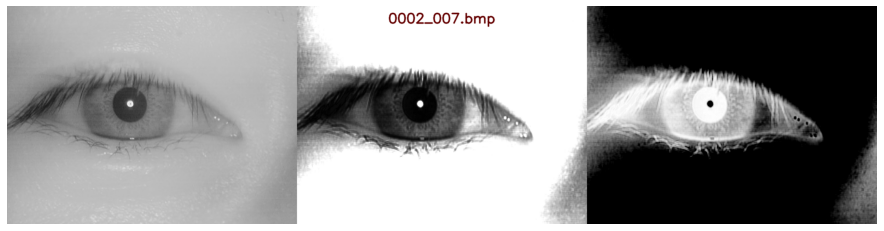

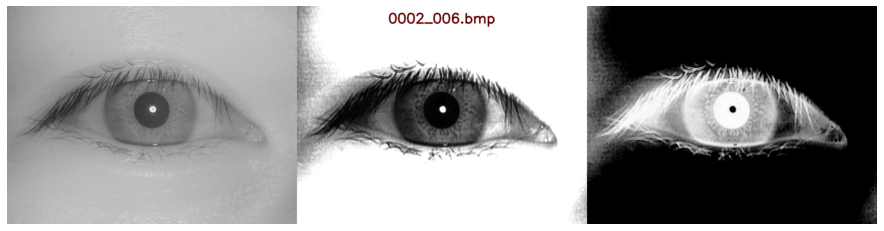

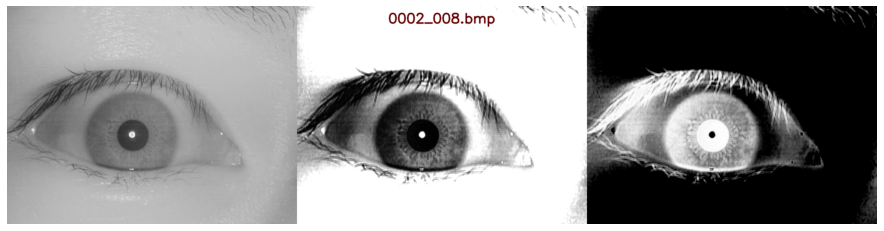

In [534]:
# process_category(input_dir,'0000', limit=1)
# process_category(input_dir,'0001', limit=1)
process_category(input_dir,'0002', show=True, save=True)
# process_category(input_dir,'0003', limit=1, show=False)
# process_category(input_dir,'0004', limit=1)
# process_category(input_dir,'0005', limit=1)

In [535]:
import G6_iris_recognition
G6_iris_recognition.iris_model_train(input_dir + '_tmp', "model.pickle")

directory_list ['images_tmp/0002']
name 0002
path_to_image images_tmp/0002/0002_011.bmp
locate expression 1 module 'skimage.draw' has no attribute 'disk'
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp/0002/0002_005.bmp
locate expression 1 module 'skimage.draw' has no attribute 'disk'
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp/0002/0002_017.bmp
locate expression 1 module 'skimage.draw' has no attribute 'disk'
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp/0002/0002_001.bmp
locate expression 1 module 'skimage.draw' has no attribute 'disk'
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp/0002/0002_016.bmp
locate expression 1 module 'skimage.draw' has no attribute 'disk'
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image images_tmp/0002/0002_013.bmp
locate expression

[]

In [536]:
for category in listdir("images-tutorial_tmp"):
    print("\nCategory", category)
    for img_name in listdir(f"images-tutorial_tmp/{category}"):
        iris_name = G6_iris_recognition.iris_model_test("model.pickle", f"images-tutorial_tmp/{category}/{img_name}")
        print(f"{img_name} detected as '{iris_name}' and should be '{img_name.split('_')[0]}'")

FileNotFoundError: ignored

# **EXERCÍCIO**

*   Construir um treinamento no módulo G6 com duas íris de cada uma das cinco primeiras pessoas (0001 a 0004) (clonar https://github.com/lucianosilva-github/images.git)
*   Verificar a qualidade do treinamento testando cada uma das íris usadas no treinamento



In [ ]:
#seu código vai aqui

# **EXERCÍCIO**

Será que a qualidade das imagens influencia na qualidade do treinamento ? Analise e experimente melhorar a qualidade das imagens usadas no exercício anterior, tendo como base as técnicas estudadas na disciplina até o momento.

In [ ]:
#seu código vai aqui

**PROJETO IRIS - DATA DE ENTREGA: 07/10/2020**


*   Crie um modelo de treinamento usando a base de dados fornecida (60 pessoas com 20 íris cada ~ 1200 imagens). Durante o treinamento, você pode utilizar qualquer procedimento para melhorar a qualidade das imagens.
*   Obtenha a matriz de confusão do seu modelo e analise os resultados

**O que entregar:** notebook implementado em Python. 


